Download employee_reviews.csv from https://www.kaggle.com/petersunga/google-amazon-facebook-employee-reviews

In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# show plots
%matplotlib inline 
from scipy import stats
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split
# fix random seed for reproducibility
numpy.random.seed(7)

# keep the top n words, zero the rest
# this is used for tokenizer and embedding
top_words = 5000

def tidy_count(df,groupbyvars):
    stats = df.groupby(groupbyvars).size().\
           reset_index().rename(columns={0: 'n'}).sort_values('n',ascending=False)
    stats['percent'] = stats['n'] / sum(stats['n'])
    return(stats)

https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [14]:
# Load data
reviews = pd.read_csv('employee_reviews.csv')
reviews['overall-ratings'] = reviews['overall-ratings'].astype(int) # convert to int
# Create binary flag for if the review was positive (4+)
reviews['pos_ovr'] = False
reviews.loc[reviews['overall-ratings'] >= 4,'pos_ovr'] = True

In [111]:
tidy_count(reviews,'pos_ovr')

,pos_ovr,n,percent
1,True,45688,0.676569
0,False,21841,0.323431


In [6]:
#reviews.dtypes

In [98]:
reviews.sample(3)

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link,pos_ovr
9345,9346,amazon,none,"Aug 21, 2018",Former Employee - Anonymous Employee,Fulfillment Associate,"Voluntary over time, voluntary time off",10+ hour days on your feet.,none,3,3.0,3.0,1.0,3.0,4.0,0,https://www.glassdoor.com/Reviews/Amazon-Revie...,False
60586,60587,microsoft,"Redmond, WA","Nov 22, 2010",Current Employee - Intl Project Engineer,International Project Engineer,One of the best reasons to work at Microsoft i...,One potential downside working at Microsoft ca...,Something that would really make a difference ...,3,3.0,none,3.0,3.0,3.0,0,https://www.glassdoor.com/Reviews/Microsoft-Re...,False
7716,7717,google,none,"May 10, 2009",Former Employee - Accountant,Great place,I've also heard about how Google's stack ranki...,A few years ago during the internet boom we al...,Is Google a utopian work envionment that dishe...,5,5.0,none,5.0,5.0,5.0,2,https://www.glassdoor.com/Reviews/Google-Revie...,True


In [124]:
reviews_sample = reviews.sample(n=10000,random_state=42)

In [125]:
# CV split
X_train, X_test, y_train, y_test = train_test_split(reviews_sample['pros'] + ' ' + reviews_sample['cons'], reviews_sample['pos_ovr'],
        test_size=0.33, random_state=42)

In [126]:
tkizer = Tokenizer(num_words=top_words) # initialize
# fit the tokenizer object on the documents
tkizer.fit_on_texts(X_train.tolist() + X_test.tolist())

In [127]:
# Tokenize into sequences
X_train_tokens = tkizer.texts_to_sequences(X_train)
X_test_tokens = tkizer.texts_to_sequences(X_test)

In [128]:
# Find word count for each document
token_lengths = [len(x) for x in X_train_tokens] + [len(x) for x in X_test_tokens]

Plot the number of words in each document

(0, 500)

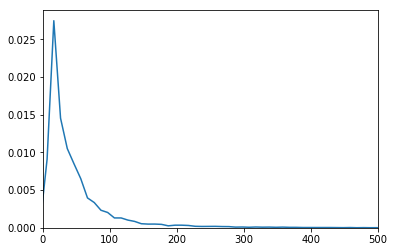

In [129]:
sns.distplot(token_lengths, hist=False, rug=False)
plt.xlim(0, 500)

In [130]:
len(X_train)

6700

In [131]:
#tkizer.word_index

In [132]:
# truncate and pad input sequences
max_review_length = 300 # maximum number of words we look at in a review
X_train_pad = sequence.pad_sequences(X_train_tokens, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test_tokens, maxlen=max_review_length)

In [133]:
# create the model
embedding_vecor_length = 32

model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
#model.add(Dropout(0.2))
model.add(LSTM(100,dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 32)           160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Train on 6700 samples, validate on 3300 samples
Epoch 1/10
6700/6700 [==============================] - 20s 3ms/step - loss: 0.6467 - acc: 0.6630 - val_loss: 0.6155 - val_acc: 0.6803
Epoch 2/10
6700/6700 [==============================] - 18s 3ms/step - loss: 0.6036 - acc: 0.6725 - val_loss: 0.5865 - val_acc: 0.7036
Epoch 3/10
6700/6700 [==============================] - 19s 3ms/step - loss: 